In [1]:
%run stdPackages.ipynb
slides = False # print to slides format if True
out_folder = os.path.join(d['curr'], 'Misc', 'Figs')
d['data'] = os.path.join(d['curr'],'Misc','Data')
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories']}
db = dbFromWB(os.path.join(d['data'],'mBasicInt1.xlsx'), read)
readSets(db)

C:\Users\xnh825\Anaconda3\envs\EEotGT\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\xnh825\Documents\GitHub\EnergyEconomicsE2022\py\readDatabase.py:63: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  var = pd.DataFrame(pd_sheet.iloc[1:,1:].values, index = pd.Index(pd_sheet.iloc[1:,0],name=domains[1]), columns = pd.Index(pd_sheet.iloc[0,1:], name = domains[2])).stack()


Set up model and solve:

In [2]:
m = mBasicInt.mSimple(db)
m.solve()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


C:\Users\xnh825\Anaconda3\envs\EEotGT\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\xnh825\Anaconda3\envs\EEotGT\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


#### Capacity Factors

Inspect capacity factors compared to marginal costs:from matplotlib.ticker import MaxNLocator

In [3]:
types = {'id1': 'Coal', 'id2': 'Gas', 'id3': 'Bio', 'id4': 'Wind'}

In [4]:
df = pd.DataFrame({'TCF': mBasicInt.theoreticalCapacityFactor(m.db), 
                   'PCF': mBasicInt.practicalCapacityFactor(m),
                   'mc' : m.db['mc']}).sort_values(by='mc')
df.index = df.index.map(types)

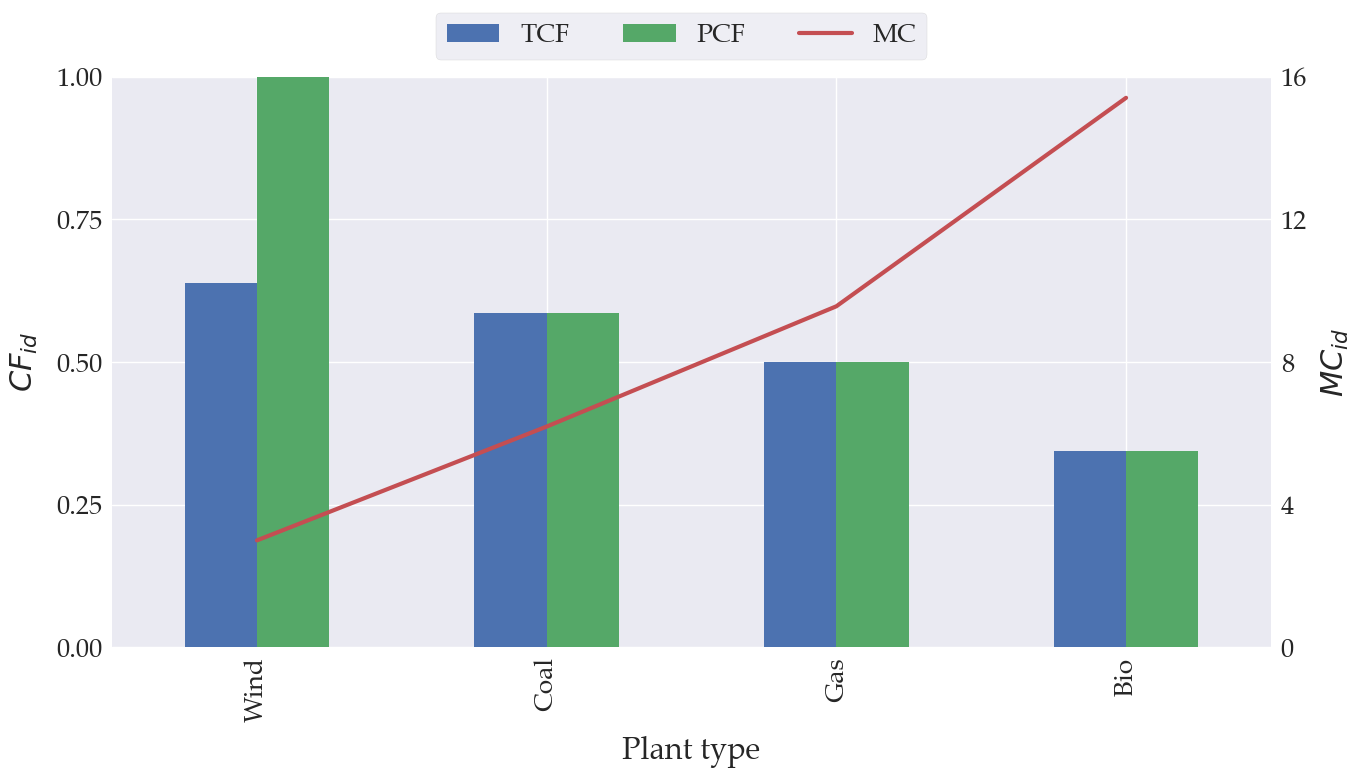

In [5]:
# %%capture
one_graph()
fig, ax1 = plt.subplots(1,1,figsize = (14,8))
ax2 = ax1.twinx()
df[['TCF','PCF']].plot.bar(ax=ax1, legend=False, linewidth=0)
ax1.set_yticks(np.linspace(0, 1, 5))
ax1.set_ylim([0, 1]);
ax1.set_ylabel('$CF_{id}$', labelpad=10);
ax1.set_xlabel('Plant type', labelpad=10);

df['mc'].plot(ax=ax2, legend=False, linewidth=3, color = colors[2]);
ax2.set_yticks(np.linspace(0, 16, 5))
ax2.set_ylim([0, 16]);
ax2.set_ylabel('$MC_{id}$', labelpad=10);
ax2.grid(None);

fig.legend(['TCF', 'PCF', 'MC'],loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);

if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_CF_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_CF.pdf",edgecolor='k')

#### Average capacity costs, average energy costs

Plot average FOM costs:

FOM with plant types instead of ids:

In [6]:
df.index

Index(['Wind', 'Coal', 'Gas', 'Bio'], dtype='object', name='id')

In [7]:
s = m.db['FOM'].set_axis(m.db['FOM'].index.map(types)).reindex(df.index)

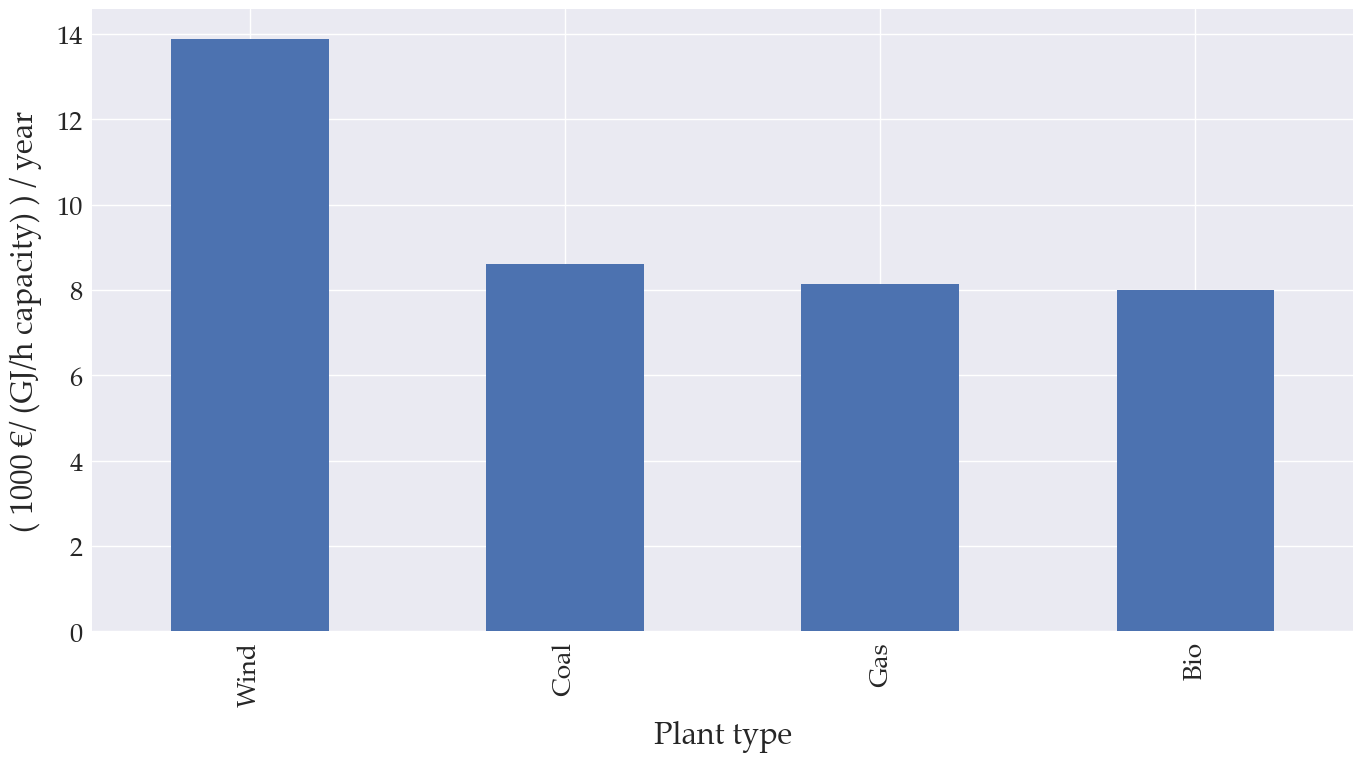

In [9]:
# %%capture
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
s.plot.bar(ax=ax, legend=False);
ax.set_ylabel('( 1000 €/ (GJ/h capacity) ) / year', labelpad=10);
ax.set_xlabel('Plant type', labelpad=10);
fig.tight_layout();
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_FOM_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_FOM.pdf",edgecolor='k')

Plot average capacity costs and energy costs against marginal costs:

In [10]:
fcosts = mBasicInt.fixedCosts(m.db) * 1000
fcosts_ACC = fcosts/m.db['GeneratingCapacity']
fcosts_AEC = fcosts/pdSum(m.db['Generation'], 'h')

In [11]:
df = pd.concat({('variable','ACC'): m.db['capacityCosts']-fcosts_ACC,
                ('fixed', 'ACC'): fcosts_ACC,
                ('variable','AEC'): m.db['energyCosts']-fcosts_AEC,
                ('fixed', 'AEC'): fcosts_AEC,
                ('', 'mc'): m.db['mc']}, names = ['type','variable']).unstack(['variable','type']).sort_values(by='mc')
df.index = df.index.map(types)

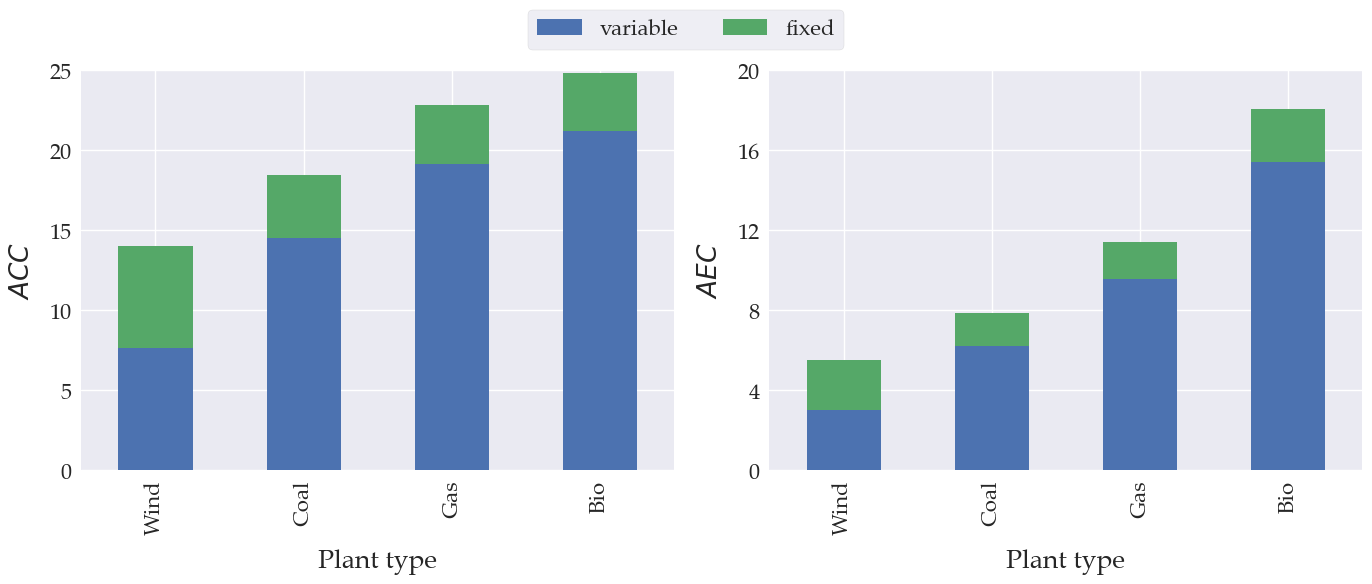

In [12]:
# %%capture
mult_graphs()
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (6*nrows)));
plt.subplots_adjust(hspace=0.35)
# Plot 1:
ax = plt.subplot(nrows, min(nplots,2), 1)
df['ACC'].plot.bar(ax=ax, stacked=True, legend=False)
ax.set_xlabel('Plant type', labelpad=10);
ax.set_ylabel("$ACC$", labelpad=10);
ax.set_yticks(np.linspace(0, 25, 6))
ax.set_ylim([0, 25]);

# Plot 2: Zooming in
ax = plt.subplot(nrows, min(nplots,2), 2)
df['AEC'].plot.bar(ax=ax, stacked=True, legend=False);
ax.set_xlabel('Plant type', labelpad=10);
ax.set_ylabel("$AEC$",labelpad=10);
ax.set_yticks(np.linspace(0, 20, 6))
ax.set_ylim([0, 20]);

fig.legend(df['ACC'].columns,loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.88);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_ACC_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_ACC.pdf",edgecolor='k')

#### Marginal economic value:

Plot marginal economic value decomposed into revenue and costs part:

In [13]:
mBasicInt.marginalEconomicValue(m)

id
id1    24.092022
id2    17.566069
id3     5.944347
id4    11.100167
dtype: object

In [14]:
df = pd.DataFrame({'revenue': mBasicInt.marginalEconomicRevenue(m),
                   'costs': mBasicInt.marginalEconomicValue(m)-mBasicInt.marginalEconomicRevenue(m),
                   'value': mBasicInt.marginalEconomicValue(m)
                  }).sort_values(by='value', ascending = False)
df.index = df.index.map(types)

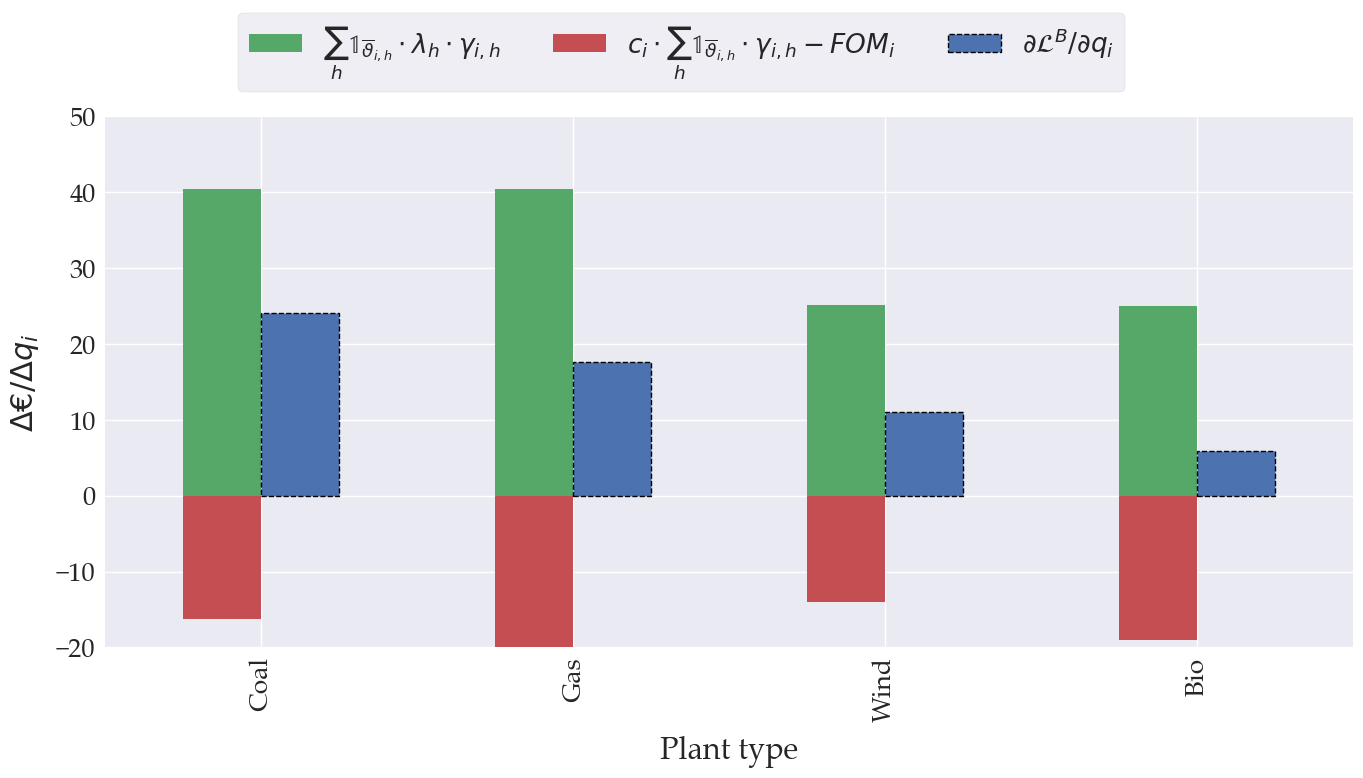

In [15]:
# %%capture
one_graph()
fig, ax1 = plt.subplots(1,1,figsize = (14,8))

df[['revenue','costs']].plot.bar(ax=ax1, stacked=True, color = colors[1:3], align='edge', width = -0.25, legend=False)
ax1.set_ylim([-20, 50]);
ax1.set_ylabel('$\Delta €/\Delta q_i$', labelpad=10);
ax1.set_xlabel('Plant type', labelpad=10);


ax2 = ax1.twinx()
df['value'].plot.bar(ax=ax2, color = colors[0], align='edge', width = 0.25, linestyle = '--', edgecolor = 'k', linewidth = 1, legend=False)
ax2.set_ylim([-20, 50]);
ax2.set_yticks([])
ax2.set_xlim([-.5, len(df['value'])-0.5])


fig.legend(['$\sum_h \mathbb{1}_{\overline{\\vartheta}_{i,h}}\cdot \lambda_h \cdot \gamma_{i,h}$', 
            '$ c_i\cdot \sum_h \mathbb{1}_{\overline{\\vartheta}_{i,h}} \cdot \gamma_{i,h}-FOM_i$', 
            '$\partial \mathcal{L}^B/\partial q_i$'],
           loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.85);

if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_EconomicValue_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_EconomicValue.pdf",edgecolor='k')